In [1]:
import arviz as az
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.handlers import seed
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoDelta, AutoNormal
from numpyro.infer.util import log_density
from scipy.interpolate import InterpolatedUnivariateSpline

from stream_membership import ComponentMixtureModel, ModelComponent
from stream_membership.distributions import IndependentGMM, TruncatedNormalSpline
from stream_membership.plot import plot_data_projections

## Simulate data

First we generate some simulated data to have a similar complexity to real stream data.

In [2]:
phi1_lim = (-100, 20)
phi2_lim = (-8, 4)
# pm1_lim = (None, -2.0)
pm1_lim = (-15., -2.0)  # DEBUG

In [3]:
N_data = 8192

# first, the background:
keys = jax.random.split(jax.random.PRNGKey(42), num=9)
N = int(N_data * 0.55)
data = {
    "phi1": dist.TruncatedNormal(
        loc=-70, scale=30, low=phi1_lim[0], high=phi1_lim[1]
    ).sample(keys[1], (N,)),
    "phi2": dist.Uniform(*phi2_lim).sample(keys[2], (N,)),
}
true_pm1_loc_spl = InterpolatedUnivariateSpline(
    [-100, -20, 0.0, 20], [-5.0, -1.0, 2.0, 5.0]
)
true_pm1_scale = 2.0
data["pm1"] = dist.TruncatedNormal(
    loc=true_pm1_loc_spl(data["phi1"]), scale=2, high=pm1_lim[1]
).sample(keys[3])

# now, add a "stream":
keys = jax.random.split(jax.random.PRNGKey(412), num=6)
N_stream = int(0.85 * (N_data - N))
stream_data = {}
true_phi1_loc = -20.0
true_phi1_scale = 40.0
stream_data["phi1"] = dist.TruncatedNormal(
    loc=-20, scale=40, low=phi1_lim[0], high=phi1_lim[1]
).sample(keys[1], (N_stream,))

true_phi2_loc_spl = InterpolatedUnivariateSpline(
    [-100, -60, -20, 0, 20], [-6, -2, 0, 0, -1], k=3
)
true_phi2_ln_scale_spl = InterpolatedUnivariateSpline(
    [-100, -60, -20, 0, 20], np.log([0.8, 0.6, 0.5, 0.5, 0.8]), k=3
)
stream_data["phi2"] = TruncatedNormalSpline(
    loc_vals=[-6, -2, 0, 0, -1],
    scale_vals=[0.8, 0.6, 0.5, 0.5, 0.8],
    knots=[-100, -60, -20, 0, 20],
    low=phi2_lim[0],
    high=phi2_lim[1],
    x=stream_data["phi1"],
).sample(keys[2])

true_pm1_loc_spl = InterpolatedUnivariateSpline(
    [-100, -60, -20, 0, 20], [-3, -6, -9, -6, -4], k=3
)
true_pm1_ln_scale = np.log(0.05)
stream_data["pm1"] = TruncatedNormalSpline(
    loc_vals=[-3, -6, -9, -6, -4],
    scale_vals=np.full(5, 0.05),
    knots=[-100, -60, -20, 0, 20],
    low=pm1_lim[0],
    high=pm1_lim[1],
    x=stream_data["phi1"],
).sample(keys[3])

# Optionally: add an "off-track" feature
N_offrack = N_data - N - N_stream
offtrack = {}
offtrack["phi1"] = dist.TruncatedNormal(
    loc=-30, scale=6, low=phi1_lim[0], high=phi1_lim[1]
).sample(keys[4], (N_offrack,))

offtrack["phi2"] = TruncatedNormalSpline(
    loc_vals=np.array([-6.0, -2.0, 0.5, 2, 2.5, 2.5]),
    scale_vals=np.full(6, 0.3),
    knots=[-100, -60, -40, -20, 0, 20],
    low=phi2_lim[0],
    high=phi2_lim[1],
    x=offtrack["phi1"],
).sample(keys[5])

offtrack["pm1"] = TruncatedNormalSpline(
    loc_vals=[-3, -6, -9, -6, -4],
    scale_vals=np.full(5, 0.05),
    knots=[-100, -60, -20, 0, 20],
    low=pm1_lim[0],
    high=pm1_lim[1],
    x=offtrack["phi1"],
).sample(keys[6])

data = {k: jnp.concatenate([data[k], stream_data[k], offtrack[k]]) for k in data}
print(N_data, N, N_stream, N_offrack)

pm1_err = jnp.exp(jax.random.uniform(keys[7], minval=-5, maxval=0, shape=(N_data,)))
data["pm1"] = jax.random.normal(keys[8], shape=(N_data,)) * pm1_err + data["pm1"]
err = {"pm1": pm1_err}

mask = data["pm1"] < pm1_lim[1]
data = {k: data[k][mask] for k in data}
err = {k: err[k][mask] for k in err}
print(data["phi1"].shape[0])

8192 4505 3133 554
8017


Text(0.5, 0.98, 'simulated data')

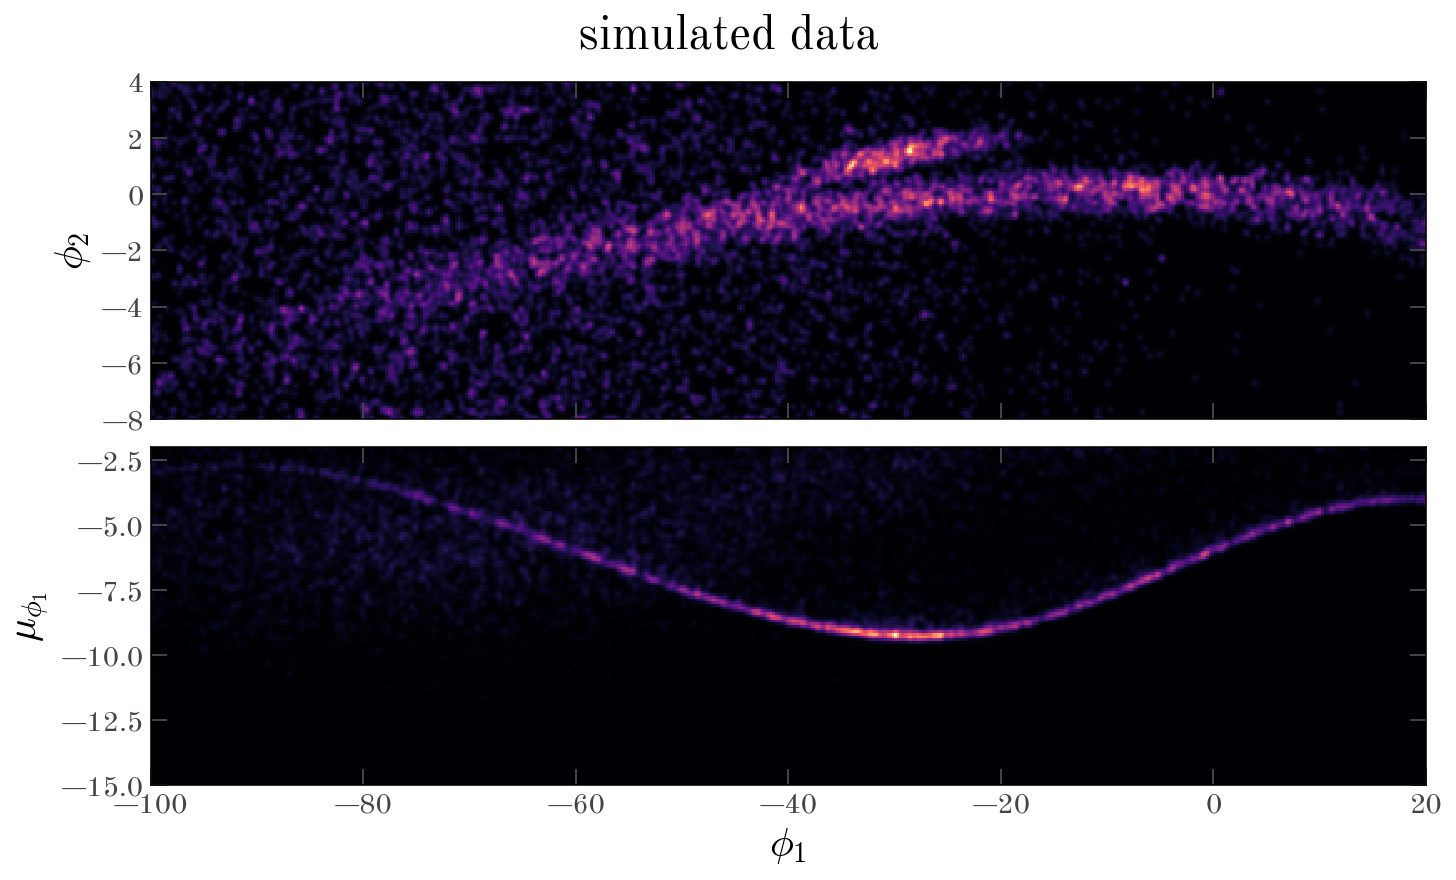

In [4]:
plot_grids = {
    "phi1": jnp.linspace(*phi1_lim, 512),
    "phi2": jnp.linspace(*phi2_lim, 128),
    "pm1": jnp.linspace(-15, pm1_lim[1], 128),
}
fig, axes = plot_data_projections(data, grids=plot_grids)
fig.suptitle("simulated data", fontsize=24)

## Background model component

The sky distribution is represented by a grid of 2D Normal distributions. The grid Normal components have different learned scales for the $\phi_1$ and $\phi_2$ directions. The proper motion track is a truncated Normal with a mean and log-stddev that are spline functions of $\phi_1$.

In [5]:
bkg_pm1_knots = jnp.arange(-100, 20 + 1e-3, 30)

bkg_model = ModelComponent(
    name="background",
    coord_distributions={
        "phi1": dist.TruncatedNormal,
        "phi2": dist.Uniform,
        "pm1": TruncatedNormalSpline,
    },
    coord_parameters={
        "phi1": {
            "loc": dist.Normal(-70.0, 50.0),
            "scale": dist.HalfNormal(50.0),
            "low": phi1_lim[0],
            "high": phi1_lim[1],
        },
        "phi2": {
            "low": phi2_lim[0],
            "high": phi2_lim[1],
        },
        "pm1": {
            "loc_vals": dist.Normal(pm1_lim[1], 1.0).expand([bkg_pm1_knots.shape[0]]),
            "scale_vals": dist.HalfNormal(5).expand([bkg_pm1_knots.shape[0]]),
            "knots": bkg_pm1_knots,
            "x": data["phi1"],
            "low": pm1_lim[0],
            "high": pm1_lim[1],
            "spline_k": 3,
            "clip_locs": (-10, pm1_lim[1]),
            "clip_scales": (1e-3, None),
        },
    },
    conditional_data={"pm1": {"x": "phi1"}},
)

In [6]:
bkg_init_params = {
    "phi1": {"loc": -70.0, "scale": 30.0},
    "phi2": {},
    "pm1": {
        "loc_vals": jnp.full(bkg_pm1_knots.shape[0], -5.0),
        "scale_vals": jnp.full(bkg_pm1_knots.shape[0], 5.0),
    },
}

Evaluate the background model at the initial parameters:

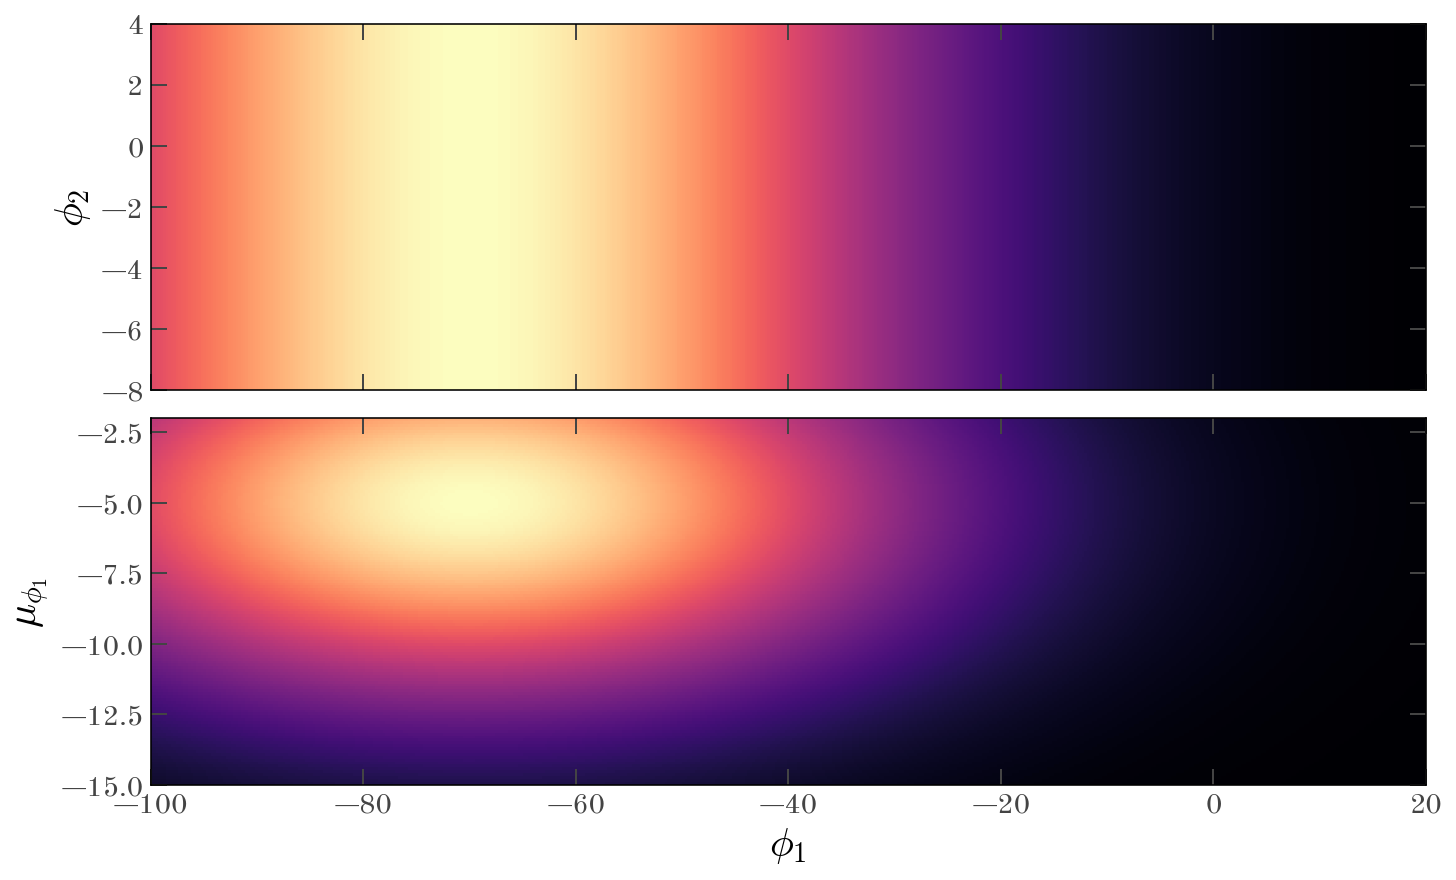

In [7]:
_ = bkg_model.plot_model_projections(bkg_init_params, grids=plot_grids)

## Stream model component

The stream model is defined using a 1D mixture of Normal distributions for the $\phi_1$ density, and conditional Normal distributions for $\phi_2$ and $\mu_1$ tracks. 

In [8]:
stream_phi1_knots = jnp.arange(-100.0, 20 + 1e-3, 10)
stream_phi2_knots = jnp.arange(-100.0, 20 + 1e-3, 15)
stream_pm1_knots = jnp.arange(-100.0, 20 + 1e-3, 15)

pm1_knots = jnp.arange(-100.0, 20 + 1e-3, 15)
stream_model = ModelComponent(
    name="stream",
    coord_distributions={
        "phi1": IndependentGMM,
        "phi2": TruncatedNormalSpline,
        "pm1": TruncatedNormalSpline,
    },
    coord_parameters={
        "phi1": {
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.ones(len(stream_phi1_knots))),
            ),
            "locs": stream_phi1_knots.reshape(1, -1),
            "scales": dist.HalfNormal(5.0),
            "low": jnp.array([phi1_lim[0]])[:, None],
            "high": jnp.array([phi1_lim[1]])[:, None],
        },
        "phi2": {
            "loc_vals": dist.Uniform(*phi2_lim).expand([stream_phi2_knots.shape[0]]),
            # "scale_vals": dist.Uniform(-6, 1).expand([stream_phi2_knots.shape[0]]),
            "scale_vals": dist.HalfNormal(1.0).expand([stream_phi2_knots.shape[0]]),
            "knots": stream_phi2_knots,
            "x": data["phi1"],
            "low": phi2_lim[0],
            "high": phi2_lim[1],
            "spline_k": 3,
            "clip_scales": (1e-3, None),
        },
        "pm1": {
            "loc_vals": dist.Uniform(-15, pm1_lim[1]).expand(
                [stream_pm1_knots.shape[0]]
            ),
            # "ln_scale_vals": dist.Uniform(-6, 1),
            "scale_vals": dist.HalfNormal(1.0),
            # "scale_vals": dist.Uniform(0.1, 1.0),
            "knots": stream_pm1_knots,
            "x": data["phi1"],
            "low": pm1_lim[0],
            "high": pm1_lim[1],
            "spline_k": 3,
            "clip_locs": (-10.0, pm1_lim[1]),
            "clip_scales": (1e-3, None),
        },
    },
    conditional_data={"phi2": {"x": "phi1"}, "pm1": {"x": "phi1"}},
)

In [9]:
stream_init_params = {
    "phi1": {
        "mixing_distribution": jnp.ones(len(stream_phi1_knots))
        / len(stream_phi1_knots),
        "scales": 10.0,
    },
    "phi2": {
        "loc_vals": jnp.full(stream_phi2_knots.shape[0], 0.0),
        "scale_vals": jnp.full(stream_phi2_knots.shape[0], 0.5),
    },
    "pm1": {
        "loc_vals": jnp.full(stream_pm1_knots.shape[0], -5.0),
        "scale_vals": 0.1,
    },
}

In [10]:
# DEBUG:
stream_model.sample(jax.random.PRNGKey(42), pars=stream_init_params)

from stream_membership.distributions.stacked_component import _StackedModelComponent
wtf = _StackedModelComponent(stream_model, pars=stream_init_params)
wtf.sample(jax.random.PRNGKey(42))

Array([ 3.65874775, -0.10873352, -4.98218582], dtype=float64)

Evaluate the stream model at the initial parameters:

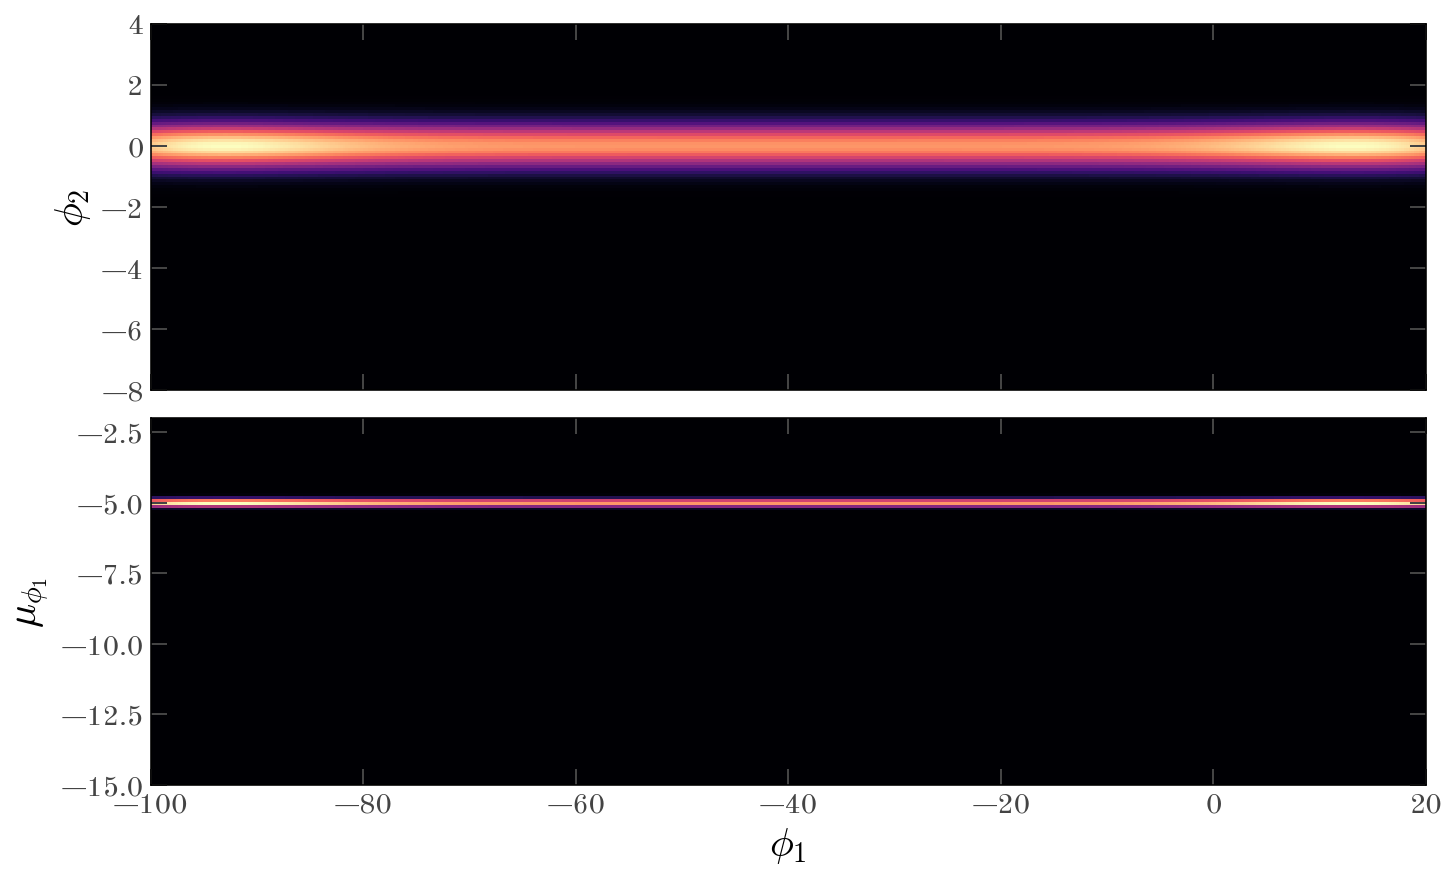

In [11]:
_ = stream_model.plot_model_projections(stream_init_params, grids=plot_grids)

## Off-track model component

We also include an "off-track" model that uses the 2D grid of Normals for the sky distribution but uses the same $\mu_1$ track as the stream model. 

In [12]:
# offtrack_phi12_locs_sparse = jnp.stack(
#     jnp.meshgrid(
#         jnp.arange(phi1_lim[0], phi1_lim[1] + 1e-3, 4),
#         jnp.arange(phi2_lim[0], phi2_lim[1] + 1e-3, 1.0),
#     ),
#     axis=-1,
# ).reshape(-1, 2)
# offtrack_phi12_locs_dense = jnp.stack(
#     jnp.meshgrid(
#         jnp.arange(-50.0, -10.0 + 1e-3, 1),
#         jnp.arange(-2.0, 3.0 + 1e-3, 0.25),
#     ),
#     axis=-1,
# ).reshape(-1, 2)
# offtrack_phi12_locs = jnp.concatenate(
#     (offtrack_phi12_locs_sparse, offtrack_phi12_locs_dense), axis=0
# )
# jnp.unique(offtrack_phi12_locs, axis=0).shape, offtrack_phi12_locs.shape

In [13]:
offtrack_phi12_locs = jnp.stack(
    jnp.meshgrid(
        # jnp.arange(-60.0, -10.0 + 1e-3, 1.0),
        # jnp.arange(-2.0, 3.0 + 1e-3, 0.25),
        jnp.arange(-60.0, -10.0 + 1e-3, 4.0),
        jnp.arange(-2.0, 3.0 + 1e-3, 1.),
    ),
    axis=-1,
).reshape(-1, 2)

offtrack_model = ModelComponent(
    name="offtrack",
    coord_distributions={
        ("phi1", "phi2"): IndependentGMM,
        "pm1": stream_model.coord_distributions["pm1"],
    },
    coord_parameters={
        ("phi1", "phi2"): {
            "mixing_distribution": (
                dist.Categorical,
                dist.Dirichlet(jnp.full(offtrack_phi12_locs.shape[0], 0.5)),
            ),
            "locs": offtrack_phi12_locs.T,
            "scales": dist.Uniform(0.2, 10.0).expand((2, 1)),
            "low": jnp.array([phi1_lim[0], phi2_lim[0]])[:, None],
            "high": jnp.array([phi1_lim[1], phi2_lim[1]])[:, None],
        },
        # We don't need to define the parameters here, as they are the same as for the
        # stream model - this will be handled below when we combine the components into
        # a mixture model
        "pm1": stream_model.coord_parameters["pm1"],
    },
    conditional_data={"pm1": {"x": "phi1"}},
)

In [14]:
_init_prob = (
    np.exp(-0.5 * (offtrack_phi12_locs[:, 0] - -35) ** 2 / 4**2)
    * np.exp(-0.5 * (offtrack_phi12_locs[:, 1] - 1.5) ** 2 / 0.5**2)
    + 1e-5
)
_init_prob /= _init_prob.sum()

offtrack_init_params = {
    ("phi1", "phi2"): {
        "mixing_distribution": _init_prob,
        "scales": jnp.array([1.0, 0.25])[:, None],
    },
    "pm1": stream_init_params["pm1"],
}

In [15]:
# DEBUG:
offtrack_model.sample(jax.random.PRNGKey(42), pars=offtrack_init_params)

from stream_membership.distributions.stacked_component import _StackedModelComponent
wtf = _StackedModelComponent(offtrack_model, pars=offtrack_init_params)
wtf.sample(jax.random.PRNGKey(42))

Array([-40.03724784,   2.20520171,  -4.82941579], dtype=float64)

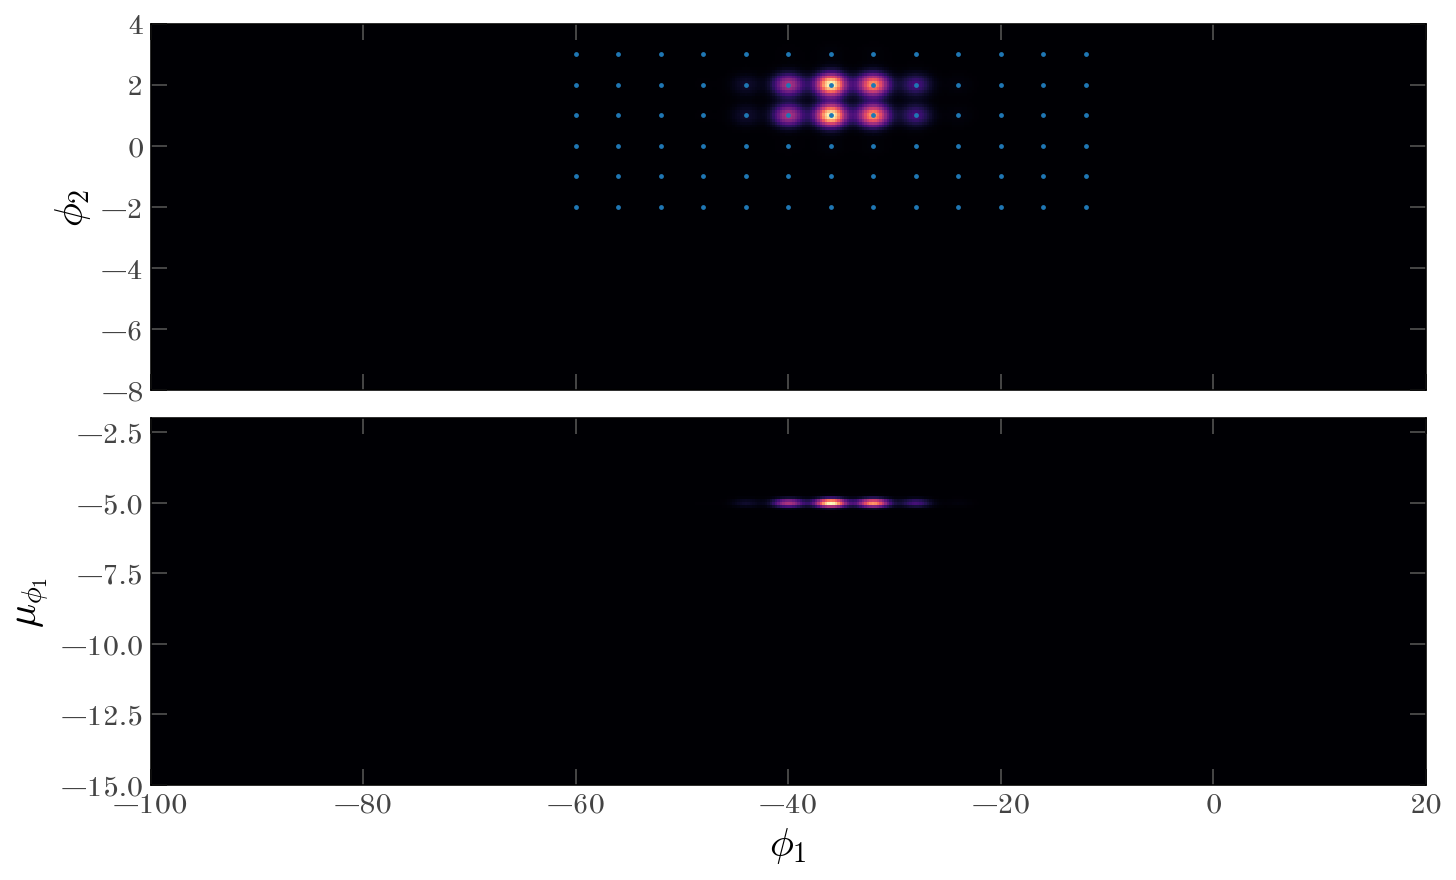

In [16]:
fig, axes = offtrack_model.plot_model_projections(
    offtrack_init_params, grids=plot_grids
)
axes[0].scatter(
    offtrack_phi12_locs[:, 0], offtrack_phi12_locs[:, 1], color="tab:blue", s=2
)

Now that we have defined the three components of the model, we combine them into a mixture model. The mixture model is a mixture of the background, stream, and off-track models. The mixture weights are learned from the data. Note that we use the `tied_coordinates` argument to specify that the off-track model "pm1" ($\mu_1$) coordinate should be "tied" to the stream model:

In [17]:
# mm = ComponentMixtureModel(
#     dist.Dirichlet(jnp.array([0.25, 0.25, 1.0])),
#     components=[bkg_model, stream_model, offtrack_model],
#     tied_coordinates={"offtrack": {"pm1": "stream"}},
# )

mm = ComponentMixtureModel(
    dist.Dirichlet(jnp.array([0.25, 0.75])),
    components=[bkg_model, stream_model],
)

Success! Now we can run an optimizer to find the MAP parameters. There are a few ways to do this with a numpyro model, but we will use the SVI machinery with a delta-function "guide" distribution, because later we will use SVI to generate posterior samples from the model. To do the optimization, we here use the Adam optimizer because we start from a random sample from the prior. In a real application, we would start from a good guess of the MAP parameters and could then use an optimizer like BFGS.

In [18]:
# # DEBUG
# key = jax.random.PRNGKey(42)
# optimizer = numpyro.optim.Adam(1e-1)
# guide = AutoDelta(
#     bkg_model, init_loc_fn=numpyro.infer.init_to_value(values=bkg_init_params)
# )
# MAP_svi = SVI(bkg_model, guide, optimizer, Trace_ELBO())

# # ---
# from numpyro.distributions.transforms import biject_to
# from numpyro.handlers import seed, substitute, trace
# from numpyro.infer.util import _unconstrain_reparam, log_density, transform_fn
# # init_strategy = numpyro.infer.init_to_sample()
# init_strategy = numpyro.infer.init_to_value(values=bkg_init_params)
# seeded_model = substitute(seed(bkg_model, key), substitute_fn=init_strategy)
# with numpyro.validation_enabled():
#     lp = log_density(
#         seeded_model, (), {"data": data, "err": err}, params=bkg_init_params
#     )
# # lp[0]  # THIS WORKS FINE

# model_trace = trace(seeded_model).get_trace(data=data, err=err)
# # model_trace  # THIS ALSO WORKS

# # ---
# # TODO: do init_params need to be the reparametrized / transformed ones???

# constrained_values, inv_transforms = {}, {}
# for k, v in model_trace.items():
#     if (
#         v["type"] == "sample"
#         and not v["is_observed"]
#         and not v["fn"].support.is_discrete
#     ):
#         constrained_values[k] = v["value"]
#         inv_transforms[k] = biject_to(v["fn"].support)
# params = transform_fn(
#     inv_transforms,
#     {k: v for k, v in constrained_values.items()},
#     invert=True,
# )

# with numpyro.validation_enabled():
#     rng_key = jax.random.PRNGKey(12345)
#     init_state = MAP_svi.init(rng_key, data=data, err=err, init_params=params)

TODO: Write a test to do a component and a mixture model of that 1 component. Should both have the same behavior.

In [19]:
optimizer = numpyro.optim.Adam(1e-1)
init_params = mm.pack_params(
    {
        "background": bkg_init_params,
        "stream": stream_init_params,
        # "offtrack": offtrack_init_params,
    }
)
# init_params["mixture-probs"] = jnp.array([0.4, 0.4, 0.2])
init_params["mixture-probs"] = jnp.array([0.4, 0.6])
init_params["mixture"] = np.stack(list(data.values()), axis=-1)
# for name in mm.coord_names:
#     init_params[f"{name}-obs"] = data[name]

guide = AutoDelta(mm, init_loc_fn=numpyro.infer.init_to_value(values=init_params))
MAP_svi = SVI(mm, guide, optimizer, Trace_ELBO())

In [24]:
# TODO: why doesn't this work???

# model_ = stream_model
# params_ = stream_init_params
model_ = mm
params_ = init_params

guide = AutoDelta(model_, init_loc_fn=numpyro.infer.init_to_value(values=params_))
MAP_svi = SVI(model_, guide, optimizer, Trace_ELBO())

from numpyro.distributions.transforms import biject_to
from numpyro.handlers import seed, substitute, trace
from numpyro.infer.util import _unconstrain_reparam, log_density, transform_fn

# init_strategy = numpyro.infer.init_to_value(values=init_params)
# seeded_model = substitute(seed(mm, jax.random.PRNGKey(42)), substitute_fn=init_strategy)
init_strategy = numpyro.infer.init_to_value(values=params_)
seeded_model = substitute(
    seed(model_, jax.random.PRNGKey(42)), substitute_fn=init_strategy
)
seeded_model(data=data, err=err)
print("call seeded model")

model_trace = trace(seeded_model).get_trace(data=data, err=err)

# constrained_values, inv_transforms = {}, {}
# for k, v in model_trace.items():
#     if (
#         v["type"] == "sample"
#         and not v["is_observed"]
#         and not v["fn"].support.is_discrete
#     ):
#         constrained_values[k] = v["value"]
#         inv_transforms[k] = biject_to(v["fn"].support)
# init_params_transformed = transform_fn(inv_transforms, constrained_values, invert=True)

with numpyro.validation_enabled():
    rng_key = jax.random.PRNGKey(12345)
    init_state = MAP_svi.init(
        rng_key, data=data, init_params=params_
    )


# TODO: the problem is with _StackedModelComponent.__init__, I think! With a Uniform
# specification of pm1 scale as a scalar??

call seeded model


We now evaluate the log-probability of the model at the initial parameters to make sure everything is in order:

In [25]:
with numpyro.validation_enabled():
    rng_key = jax.random.PRNGKey(12345)
    thing = Predictive(mm, params=init_params, num_samples=1)
    MAP_p0 = thing(rng_key, data=data, err=err)
    MAP_p0 = {k: v[0] for k, v in MAP_p0.items()}

# MAP_p0

(<Figure size 720x432 with 2 Axes>,
 array([<Axes: ylabel='$\\phi_2$'>,
        <Axes: xlabel='$\\phi_1$', ylabel='$\\mu_{\\phi_1}$'>],
       dtype=object))

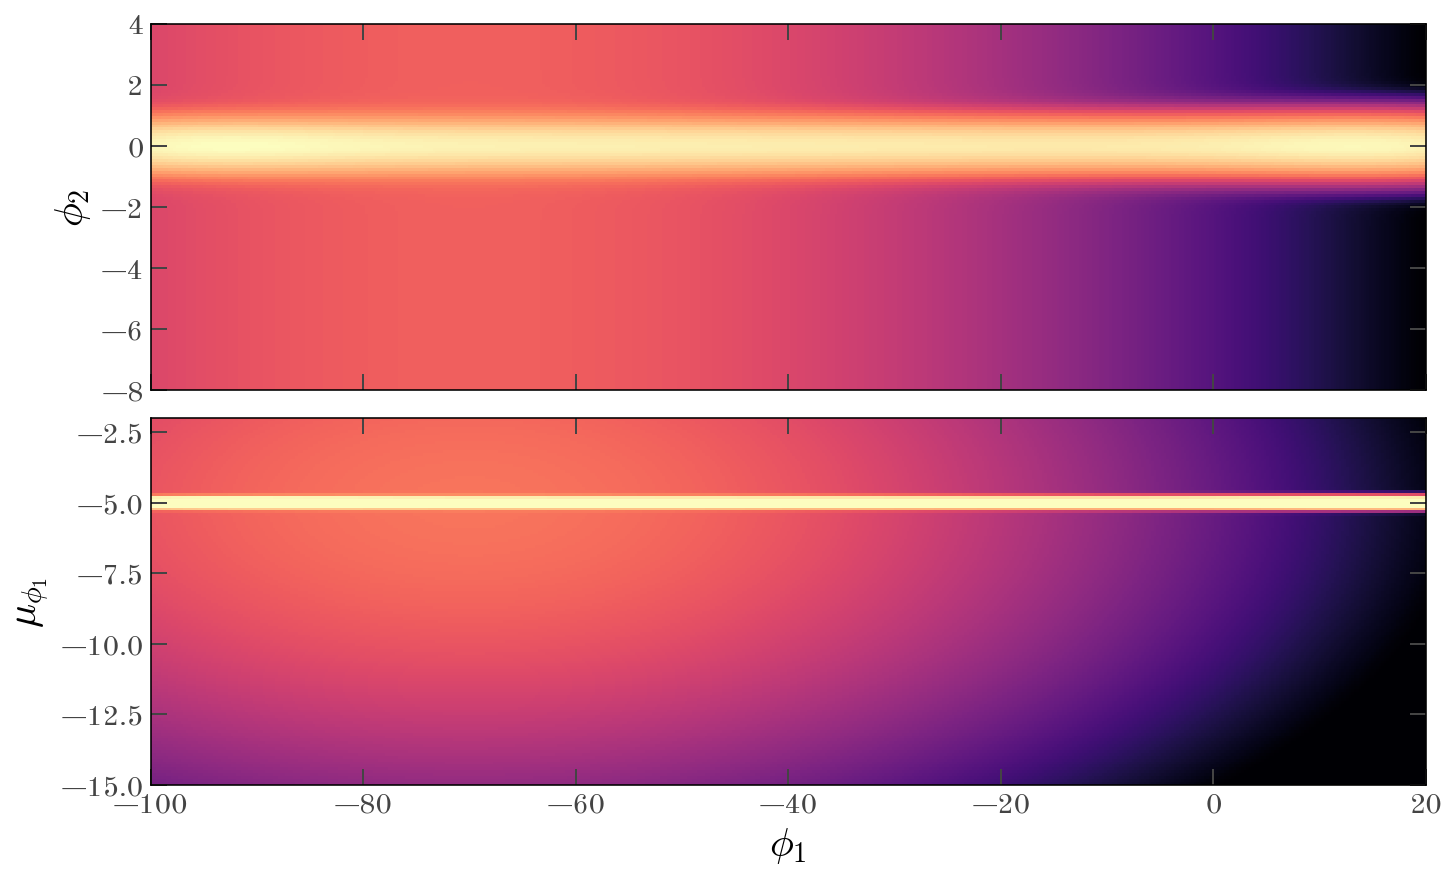

In [26]:
mm.plot_model_projections(
    init_params, plot_grids, pcolormesh_kwargs={"norm": mpl.colors.LogNorm()}
)

In [29]:
rng_key = jax.random.PRNGKey(54321)
keys = jax.random.split(rng_key, num=3)

MAP_svi_results = MAP_svi.run(
    keys[0], 200, data=data, err=err, init_params=init_params, #init_state=init_state
)
plt.plot(MAP_svi_results.losses)

  0%|          | 0/200 [00:00<?, ?it/s]/Users/apricewhelan/anaconda3/lib/python3.10/site-packages/jax/_src/linear_util.py:192: UserWarning: Found vars in model but not guide: {'mixture'}
  ans = self.f(*args, **dict(self.params, **kwargs))
 12%|█▏        | 24/200 [00:12<01:29,  1.96it/s, init loss: inf, avg. loss [11-20]: inf]


KeyboardInterrupt: 

In [38]:
thing = Predictive(guide, params=MAP_svi_results.params, num_samples=1)
MAP_p = thing(keys[1], data=data)
MAP_p = {k: v[0] for k, v in MAP_p.items()}

In [40]:
MAP_p

{'background:phi1:loc': Array(-70., dtype=float64),
 'background:phi1:scale': Array(0.02932824, dtype=float64),
 'background:pm1:loc_vals': Array([-2., -2., -2., -2., -2.], dtype=float64),
 'background:pm1:scale_vals': Array([0.00488798, 0.00488798, 0.00488798, 0.00488798, 0.00488798],      dtype=float64),
 'mixture-probs': Array([2.22507386e-308, 1.00000000e+000], dtype=float64),
 'stream:phi1:mixing_distribution': Array([0.07692308, 0.07692308, 0.07692308, 0.07692308, 0.07692308,
        0.07692308, 0.07692308, 0.07692308, 0.07692308, 0.07692308,
        0.07692308, 0.07692308, 0.07692308], dtype=float64),
 'stream:phi1:scales': Array(0.00977592, dtype=float64),
 'stream:phi2:loc_vals': Array([0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64),
 'stream:phi2:scale_vals': Array([0.00048881, 0.00048881, 0.00048881, 0.00048881, 0.00048881,
        0.00048881, 0.00048881, 0.00048881, 0.00048881], dtype=float64),
 'stream:pm1:loc_vals': Array([-5., -5., -5., -5., -5., -5., -5., -5., -5.]

(<Figure size 720x432 with 2 Axes>,
 array([<Axes: ylabel='$\\phi_2$'>,
        <Axes: xlabel='$\\phi_1$', ylabel='$\\mu_{\\phi_1}$'>],
       dtype=object))

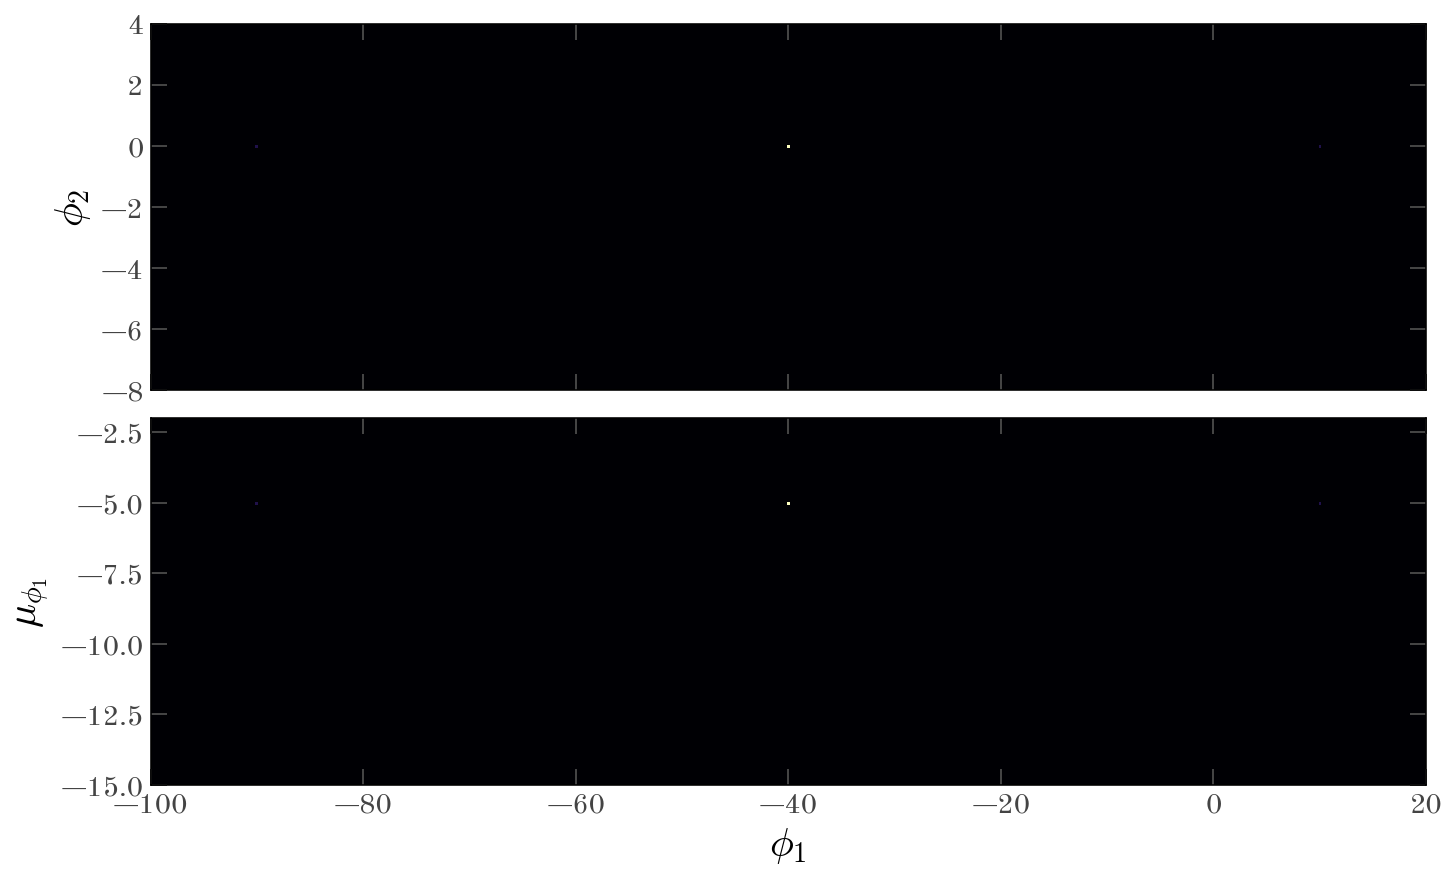

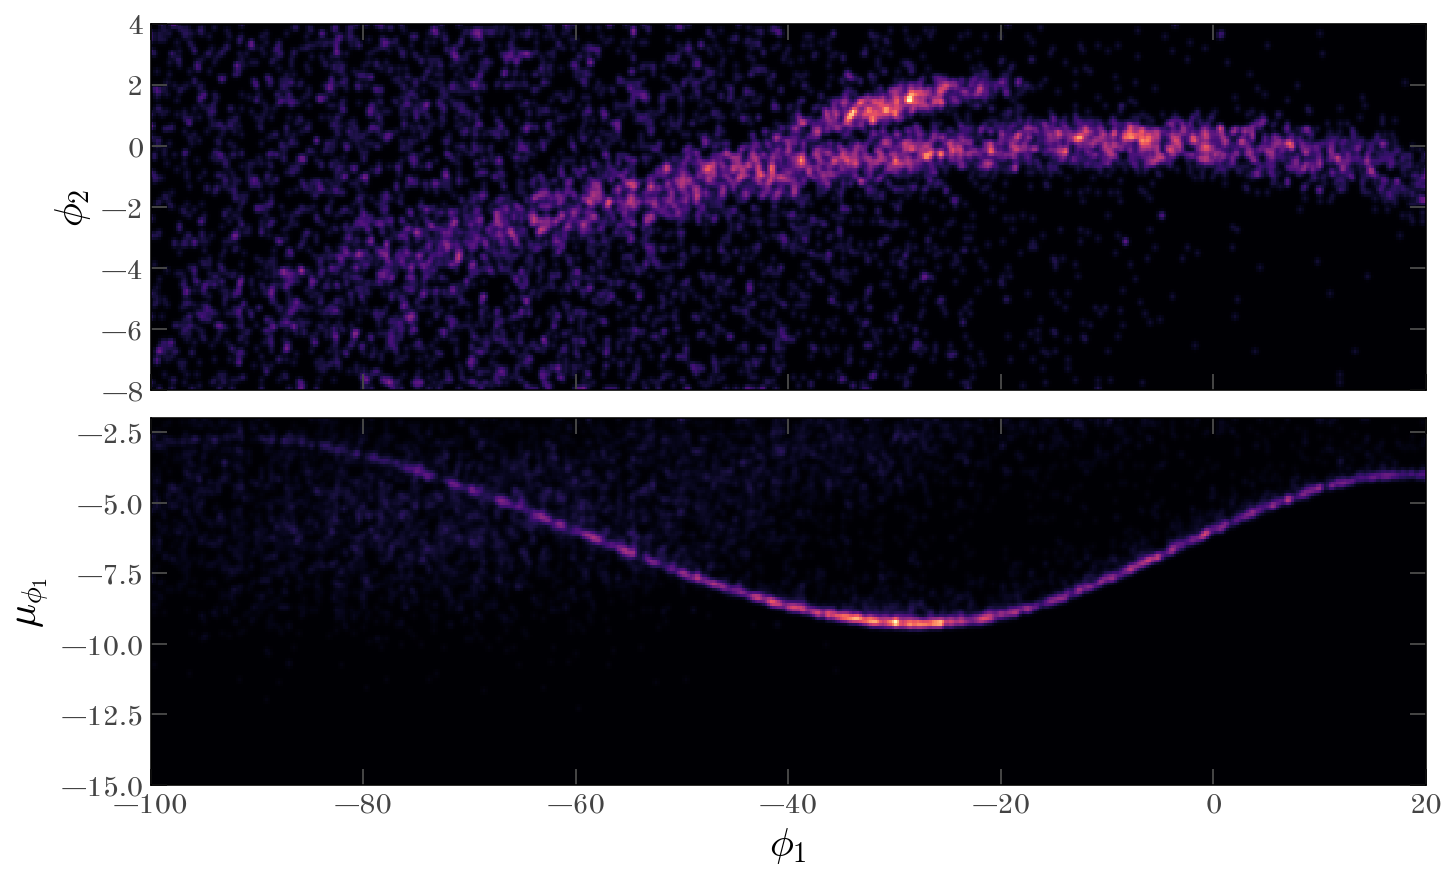

In [39]:
mm.plot_model_projections(MAP_p, plot_grids)
plot_data_projections(data, plot_grids)

In [ ]:
expanded_pars = mm.expand_numpyro_params(MAP_p)
for name in mm.component_names:
    mm._components[name].plot_model_projections(expanded_pars[name], plot_grids)

TODO: how to init guide at loc's given by MAP optimization?

In [ ]:
optimizer = numpyro.optim.Adam(1e-2)
guide = AutoNormal(mm, init_loc_fn=numpyro.infer.init_to_value(values=MAP_p))
svi = SVI(mm, guide, optimizer, Trace_ELBO())
svi_results = svi.run(jax.random.PRNGKey(0), 10_000, data=data)
plt.loglog(svi_results.losses)

In [ ]:
rng_key = jax.random.PRNGKey(123)

thing = Predictive(guide, params=svi_results.params, num_samples=100)
SVI_ps = thing(rng_key, data=data)
SVI_p = {k: v[0] for k, v in SVI_ps.items()}

In [ ]:
SVI_p

In [ ]:
mm.plot_model_projections(SVI_p, plot_grids)

In [ ]:
plt.hist(err["pm1"], bins=128, density=True)
plt.hist(np.exp(SVI_ps["stream:pm1:ln_scale_vals"]), bins=16, density=True)

In [ ]:
grids = {
    "phi1": jnp.linspace(*phi1_lim, 512),
    "phi2": jnp.linspace(*phi2_lim, 128),
    "pm1": jnp.linspace(-15, pm1_lim[1], 128),
}
mm.plot_model_projections(SVI_p, grids)
plot_data_projections(data, grids)

In [ ]:
rng_key = jax.random.PRNGKey(123987)

from numpyro.infer.util import unconstrain_fn

mcmc_p0 = unconstrain_fn(mm, (data,), {}, MAP_p)

# , init_strategy=numpyro.infer.init_to_value(values=MAP_p))
nuts_kernel = NUTS(mm, max_tree_depth=(5, 10))
mcmc = MCMC(nuts_kernel, num_warmup=1000, num_samples=100)
mcmc.run(rng_key, data=data, init_params=mcmc_p0)

In [ ]:
idata = az.from_numpyro(mcmc)
az.summary(idata.posterior)

samples = mcmc.get_samples()

In [ ]:
plt.scatter(
    stream_phi2_knots, true_phi2_loc_spl(stream_phi2_knots), marker="o", color="r"
)
plt.errorbar(
    stream_phi2_knots,
    idata.posterior["stream:phi2:loc_vals"][0].mean(axis=0),
    idata.posterior["stream:phi2:loc_vals"][0].std(axis=0),
)

In [ ]:
plt.hist(np.exp(idata.posterior["stream:pm1:ln_scale_vals"][0]), bins=32)
plt.axvline(0.05)

In [ ]:
# mean_probs = idata.posterior["bkg-grid-probs"][0].mean(axis=0)
plt.hist(idata.posterior["mixture-probs"][0, :, 0], bins=32)

Old debugging

In [24]:
model = mm
model_args = ()
model_kwargs = {"data": data, "err": err}
# model_kwargs = {"data": data}
init_strategy = numpyro.infer.init_to_sample()
key, subkey = jax.random.split(jax.random.PRNGKey(42))

from functools import partial

from numpyro.distributions.transforms import biject_to
from numpyro.handlers import seed, substitute, trace
from numpyro.infer.util import _unconstrain_reparam, log_density, transform_fn

# Wrap model in a `substitute` handler to initialize from `init_loc_fn`.
model_ = model
seeded_model = substitute(seed(model_, subkey), substitute_fn=init_strategy)
model_trace = trace(seeded_model).get_trace(*model_args, **model_kwargs)
constrained_values, inv_transforms = {}, {}
for k, v in model_trace.items():
    if (
        v["type"] == "sample"
        and not v["is_observed"]
        and not v["fn"].support.is_discrete
    ):
        constrained_values[k] = v["value"]
        inv_transforms[k] = biject_to(v["fn"].support)
params = transform_fn(
    inv_transforms,
    {k: v for k, v in constrained_values.items()},
    invert=True,
)
print(list(params.keys()))

substituted_model = substitute(
    model, substitute_fn=partial(_unconstrain_reparam, params)
)
log_joint, model_trace = log_density(substituted_model, model_args, model_kwargs, {})

CALL TOP
background:phi1:loc <numpyro.distributions.continuous.Normal object at 0x307122f50>
background:phi1:scale <numpyro.distributions.continuous.HalfNormal object at 0x3071231c0>
background:pm1:loc_vals <numpyro.distributions.distribution.ExpandedDistribution object at 0x330faf520>
background:pm1:scale_vals <numpyro.distributions.distribution.ExpandedDistribution object at 0x330fad4b0>
CALL TOP
stream:phi1:mixing_distribution <numpyro.distributions.continuous.Dirichlet object at 0x33aa29cc0>
stream:phi1:scales <numpyro.distributions.continuous.HalfNormal object at 0x33aa4cd60>
stream:phi2:loc_vals <numpyro.distributions.distribution.ExpandedDistribution object at 0x33aa4ea40>
stream:phi2:scale_vals <numpyro.distributions.distribution.ExpandedDistribution object at 0x33aa4e950>
stream:pm1:loc_vals <numpyro.distributions.distribution.ExpandedDistribution object at 0x33aa4f010>
stream:pm1:scale_vals <numpyro.distributions.continuous.Uniform object at 0x33aa4f2b0>
0.1 1.0 Interval(lowe

AssertionError: all sites must have unique names but got `background:phi1:loc` duplicated